# Developing an AI application

In [ ]:
# Imports here
%matplotlib inline
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
from workspace_utils import active_session

## Load the data

We will use [torchvision](https://pytorch.org/docs/0.3.0/torchvision/index.html) to load the data.

You can download the data used in this notebook [here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz).

The dataset is split into three parts, training, validation, and testing. 

### Some Important Notes on Training Data

During training, it is important for the network to **see** as many examples as possible associated to a particular label. A way to do this is by applying a set of transformation to the training data such as `scaling`, `cropping`, and `flipping`. This will help the network generalize leading to better performance.

Another important thing to note is the input data needs to be resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.


### Pre-trained Network

The pre-trained network we'll use were trained on the [ImageNet dataset](http://www.image-net.org/) where each color channel was normalized separately.

### Image Normalization

For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.


In [ ]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [ ]:
# TODO: Define your transforms for the training, validation, and testing sets
data_transforms = {'train':transforms.Compose([transforms.RandomRotation(45),
                             transforms.RandomResizedCrop(224), 
                             transforms.RandomHorizontalFlip(), 
                             transforms.ToTensor(), 
                             transforms.Normalize([0.485, 0.456, 0.406], 
                                                  [0.229, 0.224, 0.225])]), 
                    'test':transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), 
                            transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], 
                                                                        [0.229, 0.224, 0.225])]), 
                    'valid':transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), 
                            transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], 
                                                                        [0.229, 0.224, 0.225])])}

# TODO: Load the datasets with ImageFolder
image_datasets = {data: datasets.ImageFolder(data_dir+"/"+data, 
                                               transform=data_transforms[data]) for data in ['train','valid','test']}

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {data: torch.utils.data.DataLoader(image_datasets[data], batch_size=32, shuffle = True) 
                 for data in ['train','valid','test']}

### Label mapping

Since the flower categories are represented by integers, we will need to map them back to the original flower names. 

Please use the following file `cat_to_name.json` to map from category label to category name.

In [4]:
import json
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. We will use one of the pre-trained models from `torchvision.models` to get the image features. More information about available pre-trained networks can be found [here](https://pytorch.org/docs/master/torchvision/models.html).

The first thing we will do is to build a **new classifier** that will replace the pre-trained network's classifier. Our classifier will be a simple feed-forward network with the following properties:

 - ReLU activations
 - Dropout in both layers.

The main reason to replace the classifier is the need to adapt the pre-trained network to our particular problem. Building the **right** classifier might take some time, you'll need to add/remove layers or change drop probabilities, among other little tweaks.

It is an iterative process, my advice is to start with a simple classifier, check the evolution of both training loss and validation accuracy as you modify make changes. 

### Workflow

 - Load a pre-trained network.
 - Define a new classifier.
 - Train the new classifier and track the evolution of training/validation loss alongside with validation accuracy.
 - Test the network accuracy.
 - Save the trained model to a checkpoint.
 - Inference on a sample image.

#### 1) Load pre-trained network

In [6]:
net = models.vgg11(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /root/.torch/models/vgg11-bbd30ac9.pth
100%|██████████| 531456000/531456000 [01:11<00:00, 7448581.15it/s]


In [7]:
net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kern

#### 2) Define new classifier

In [8]:
# Freeze network parameters
for param in net.parameters():
    param.requires_grad =False

In [9]:

classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 12544)),
                                        ('relu1', nn.ReLU()),
                                        ('drop1', nn.Dropout(0.1)),
                                        ('fc2', nn.Linear(12544, 4096)),
                                        ('relu2', nn.ReLU()),
                                        ('drop2', nn.Dropout(0.1)),
                                        ('fc3', nn.Linear(4096, 102)),
                                        ('output', nn.LogSoftmax(dim=1))
                                       ]))

In [19]:
classifier

Sequential(
  (fc1): Linear(in_features=25088, out_features=12544, bias=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.1)
  (fc2): Linear(in_features=12544, out_features=4096, bias=True)
  (relu2): ReLU()
  (drop2): Dropout(p=0.1)
  (fc3): Linear(in_features=4096, out_features=102, bias=True)
  (output): LogSoftmax()
)

In [20]:
net.classifier = classifier

#### 3) Train the classifier and track metrics on validation set

In [21]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(net.classifier.parameters(), lr=0.001)

In [22]:
# Function taken from Inference and Validation Lecture, Udacity Nanodegree
def validation(model, validation_loader, criterion):
    test_loss = 0
    accuracy = 0
    for data in validation_loader:

        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [23]:
with active_session():
    epochs = 4
    print_cut = 40
    step = 0
    running_loss = 0
    # Use Cuda GPU
    net.to('cuda')
    for e in range(epochs):
        net.train()
        for index, (images, labels) in enumerate(dataloaders['train']):
            step +=1
            images, labels = images.to('cuda'), labels.to('cuda')
            # Turn-off gradient
            optimizer.zero_grad()
            # Do Forward pass
            output = net.forward(images)
            loss = criterion(output, labels)
            # Back pass
            loss.backward()
            # Optimizer step
            optimizer.step()
            # Track training loss
            running_loss += loss.item()
            # Print when you reach cut
            if step % print_cut == 0:
                # Network is on Evaluation mode
                net.eval()
                with torch.no_grad():
                    valid_loss, accuracy = validation(net, dataloaders['valid'], criterion)
                print("Epoch: {}/{}... ".format(e+1, epochs),
                      "Training Loss: {:.4f} |".format(running_loss/print_cut),
                      "Validation Loss: {:.4f} |".format(valid_loss/len(dataloaders['valid'])),
                      "Validation Accuracy: {:4f}.".format(accuracy/len(dataloaders['valid'])))    
                running_loss = 0
                # Network is back on Training mode
                net.train()

Epoch: 1/4...  Training Loss: 5.7206 | Validation Loss: 3.4186 | Validation Accuracy: 0.244124.
Epoch: 1/4...  Training Loss: 3.0846 | Validation Loss: 2.1999 | Validation Accuracy: 0.429087.
Epoch: 1/4...  Training Loss: 2.4279 | Validation Loss: 1.7184 | Validation Accuracy: 0.541800.
Epoch: 1/4...  Training Loss: 2.1045 | Validation Loss: 1.3663 | Validation Accuracy: 0.614850.
Epoch: 1/4...  Training Loss: 1.8498 | Validation Loss: 1.1931 | Validation Accuracy: 0.659322.
Epoch: 2/4...  Training Loss: 1.6415 | Validation Loss: 1.1052 | Validation Accuracy: 0.678018.
Epoch: 2/4...  Training Loss: 1.5658 | Validation Loss: 1.0994 | Validation Accuracy: 0.698184.
Epoch: 2/4...  Training Loss: 1.5190 | Validation Loss: 0.8901 | Validation Accuracy: 0.762553.
Epoch: 2/4...  Training Loss: 1.4428 | Validation Loss: 0.9875 | Validation Accuracy: 0.723691.
Epoch: 2/4...  Training Loss: 1.4887 | Validation Loss: 0.9217 | Validation Accuracy: 0.740785.
Epoch: 3/4...  Training Loss: 1.3269 | V

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images.

In [24]:
def check_accuracy_on_test(testloader, model):    
    correct = 0
    tot = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            tot += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    print('Accuracy of the network on the test images: %d %%' % (100 * correct / tot))

In [25]:
check_accuracy_on_test(dataloaders['test'], net)

Accuracy of the network on the test images: 78 %


## Save the checkpoint

Now that the network is trained, save the model so we can load it later for making predictions. 

Along with the model, we will save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```net.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`.

In [26]:
net.class_to_idx = image_datasets['train'].class_to_idx

checkpoint = {'epochs': 4,
              'print_cut':40,
              'class_idx': net.class_to_idx,
              'classifier': net.classifier,
              'model_state_dict': net.state_dict()
              }
torch.save(checkpoint, "network_checkpoint.pth")

## Loading the checkpoint

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device.type)

cuda


In [6]:
def load_network(filename, model_used, device):
    """
    Load trained model.
    """
    if device =="cuda":
        checkpoint = torch.load(filename, map_location={'cuda:1':'cuda:0'})
    else:
        checkpoint = torch.load(filename, map_location=device)
    params = checkpoint['epochs'], checkpoint['print_cut'], checkpoint['class_idx']
    model_used.classifier = checkpoint['classifier']
    model_used.load_state_dict(checkpoint['model_state_dict'])
    model_used.clas_to_idx = params[2]
    return model_used, params

In [7]:
model, params = load_network('network_checkpoint.pth', models.vgg11(pretrained=False), device.type)

# Inference for classification

Now, we we'll write a `predict` function that will take an image and the trained model as inputs and predict the class of the flower in the image.

The function will return the top $k$ most likely classes along with the probabilities.


### Image Preprocessing

We will write a function that uses `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)).

This function should process the images in the same manner used for training. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [8]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    im = Image.open(image)
    d1, d2 = im.size
    # Current ratio
    org_ratio = d1 / d2

    # Keep aspect ratio
    new_size = (256 , int(256*1/org_ratio))
    im = im.resize(new_size)
    im = im.crop((0,0,224,224))

    ## Normalizing Image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = np.array(im)/255
    np_image = (np_image - mean)/std
    np_image = np_image.transpose(2,0,1)
    return np_image

Once the image has been processed, we will use a helper function `imshow` to convert the Pytorch tensor and display it as an image.

In [9]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [10]:
img_path = train_dir+"/"+"28/image_05213.jpg"

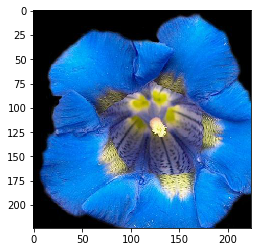

In [11]:
imshow(process_image(img_path))

## Class Prediction

As mentioned before, we will make calculate the class probabilities for an image and find the $K$ largest values along with the class labels.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [12]:
def predict(image_path, model, device, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    image = process_image(image_path)
    image = torch.from_numpy(image).type(torch.FloatTensor)
    image = image.unsqueeze_(0).to(device)
    model.to(device)
    model.eval()
    with torch.no_grad():
        output = torch.exp(model.forward(image))[0].cpu().numpy()
    index_class = { v:k for k,v in model.clas_to_idx.items()}
    top_k = sorted([(pr, index_class[index]) for index, pr in enumerate(output)], reverse=True)[:topk]
    a,v = zip(*top_k)
    return list(a),list(v)

In [13]:
probs, classes = predict(img_path, model, device.type)

In [14]:
print(probs)
print(classes)

[0.98145539, 0.0088992445, 0.007582345, 0.0016101116, 0.00018791744]
['28', '45', '9', '52', '68']


## Sanity Checking

Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs.

We will use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. 

Finally, we will convert the class labels to actual flower names using the `cat_to_name.json` file.

In [15]:
names = [cat_to_name[c] for c in classes]

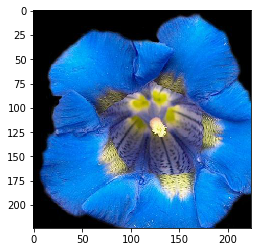

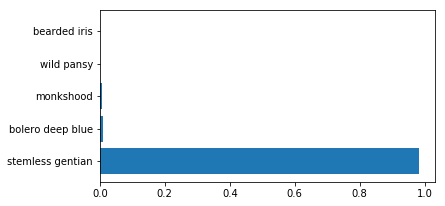

In [16]:
# TODO: Display an image along with the top 5 classes

imshow(process_image(img_path))
fig, ax = plt.subplots(figsize=(6,9), ncols=1)
plt.barh(np.arange(5), probs)
ax.set_aspect(0.1)
ax.set_yticks(np.arange(5))
_ =ax.set_yticklabels(names)